## PLACEHOLDER
### Import data
The data we are importing is stored in a PostgreSQL database. This data is the review posts on yelp ranging from April 2005 till January 2013. Each post is identified by a review id. Each review id has a corrisponding user id for the user who posted it and business id for the business being posted about. Each post includes the cool , useful , and funny votes given by the community members. 

First we need to connect and retrieve this data from the database. We can import psycopg2 which is a PostgreSQL adapter for Python used to interegrate Python with PostgreSQL. We use it to connect to my personal database namd script on the local machine. Now we can execute commands to the database. We will do this using pandas to query for the table business and return the results in dataframe. A dataframe is essentially a data object in Python that allows manipulating of data in table form, with columns and rows. Let's first test it to see what the table looks like:

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
# Connect to personal database that contains Yelp.csv data as table business
conn = psycopg2.connect(host="localhost" , dbname="script", user="adam", password="Password")
#conn = psycopg2.connect(host="localhost" , dbname="test", user="postgres", password="toor")
# Read in table business and show first 5 lines 
test_query = pd.read_sql_query("SELECT * FROM business", conn)
test_query.head()

,bid,date,rid,star,texts,texttype,uid,cool,useful,funny
0,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
1,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
2,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
3,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
4,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,Rosie Dakota and I LOVE Chaparral Dog Park!!! ...,review,uZetl9T0NcROGOyFfughhg,1,2,0


## Understanding the Data
### Finding all unique columns

Some things of notice about the data is:
1. Some columns we might not need 
2. The heading seems to be in the first row 
3. It's not clear which IDs should we consider for insight

We will solve #1 and #2 later on; for now let's solve #3. To solve #3 we should first find out how unique each column is. We do this by creating a list of both the column name and the percentage of values that are unique(0 to 1).

Our results how that review id is the only column that is completely unique with a ratio of 1. This means that every rid will reference 1 buid(business id) and 1 uid(user id) as it is impossible for any particular rid to repeat. This is oppose to bid and uid which both are only 40% and 60% unique respectively. This means we can use those two to learn more.

In [2]:
# Use list comprehention to grab all columns and use them to access each dataframe column values. 
# Then find the number of unique values and divide that number by the total number of rows
# Last put that value and the column name in a tuple and put all tuples in a list called unique
unique= [(i,(test_query[i].nunique())/len(test_query)) for i in test_query.columns]
# Turn list into a dataframe with data names as column 1 and unique length as column 2
pd.DataFrame.from_records(unique, columns=['data names' , 'unique length'])

,data names,unique length
0,bid,0.417458
1,date,0.199580
2,rid,1.000000
3,star,0.000600
4,texts,0.999800
5,texttype,0.000200
6,uid,0.640336
7,cool,0.003000
8,useful,0.002900
9,funny,0.003000


### Grouping users by the number of businesses they reviewed

So now we know business id and user id is the columns to look for. But which one do we want to be our main reference? Here user id was chosen because the users are the ones reviewing. 

Let's group users by the number of unique businesses they review and find the max , min , mean , and median. The lowest number of businesses a user reviews, not suprisingly, is 1. The highest is 38. The average number of businesses a user reviews 1.5 and the median is exactly 1. The median and mean being dissimiliar means there will be a skew affecting the value.

If we sort the range of values and print specific rows we can show the top 10 and bottom 10. From this knowledge we can see the top 10 never repeat and grow in increasing increments , while the bottom 10 is just 1 in repeat. We can guess that other low values are probably just as common amd the high values are all different. This would be why despite such a large range the average number of businesses reviewed by a user sticks around 1. Which for us means exactly 1 because businesses can not be decimals.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
length_df = test_query.groupby('uid')[['bid']].nunique()
print(length_df['bid'].describe())
min_max_10 =pd.concat([length_df.sort_values(['bid'],ascending=False).head(10), \
              length_df.sort_values(['bid'],ascending=True).head(10)], keys=['Top 10', 'Bottom 10'])

min_max_10

count    6404.000000
mean        1.561680
std         1.578922
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        38.000000
Name: bid, dtype: float64


bid
          uid                        
Top 10    fczQCSmaWF78toLEmb0Zsw   38
          0CMz8YaO3f8xu4KqQgKb9Q   25
          90a6z--_CUrl84aCzZyPsg   22
          4ozupHULqGyO42s3zNUzOQ   18
          0mqHhdKEdak_A1FBhFNXqA   18
          wHg1YkCzdZq9WBJOTRgxHQ   17
          0bNXP9quoJEgyVZu9ipGgQ   16
          _PzSNcfrCjeBxSLXRoMmgQ   16
          joIzw_aUiNvBTuGoytrH7g   15
          JgDkCER12uiv4lbpmkZ9VA   15
Bottom 10 zzmRKNph-pBHDL2qwGv9Fw    1
          ZmCfwDMuYkhpyr-hWKgiaw    1
          Zm2k6dJtqKDz3pZ70SwohA    1
          ZirtwB_QHFUGX_7x02jf5Q    1
          ZiMCaIaUlBmVnNjREY0W6Q    1
          Zi9UXJ81qMtzXRZ8mp7PxQ    1
          Zi0h5i-ZKDI9hZQgKCyDSw    1
          Zgp9T6IOVFOozrWDw_mUGQ    1
          vuxnLRJLT7EjjwIwycDAoA    1
          Zg_M3iwTqOgp-2i6Usyftg    1

### Distribution of grouping 

After creatingg a distribution plot our guess is justified. The mean is 1 which means just as much values are 1 that are in the range 2 to 38. So most users focus their attention on one business to review , probably inspired to create an account for that very reason. 

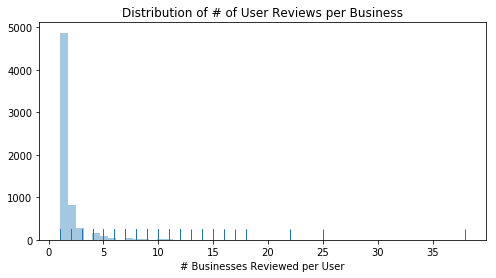

In [4]:

fig, ax = plt.subplots(figsize=(8, 4))
sns.distplot(length_df['bid'],rug=True,kde=False,hist=True,ax=ax)
plt.xlabel('# Businesses Reviewed per User')
plt.title('Distribution of # of User Reviews per Business')
plt.show()

## PLACEHOLDER
### Query & format for the right information


It's now time to get to #1 (columns that are'nt need) and #2 (bad formatting with the heading). Since we are using this data for machine learning we have no need for any of the IDs. The text type is also not useful as all the posts are labeled review. To get rid of them we will skip a Python solution all together and just select only the columns that aren't the columns mentioned using SQL. Now we will take the Dataframe returned and remove the first row and any extra data that is a side affect of our Python operations. We are leeft with a Dataframe with 6 columns and 10000 rows. None of those rows include Null and all of the columns are of datatype Object. 

In [5]:
df = pd.read_sql_query("SELECT date , star , texts, cool , useful, funny FROM business",conn)
yelp_df = pd.DataFrame(df).drop(df.index[0]).reset_index().drop(['index'] , axis=1)
print( yelp_df.info())
yelp_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
date      10000 non-null object
star      10000 non-null object
texts     10000 non-null object
cool      10000 non-null object
useful    10000 non-null object
funny     10000 non-null object
dtypes: object(6)
memory usage: 468.8+ KB
None


,date,star,texts,cool,useful,funny
0,2011-01-26,5,My wife took me here on my birthday for breakf...,2,5,0
1,2011-07-27,5,I have no idea why some people give bad review...,0,0,0
2,2012-06-14,4,love the gyro plate. Rice is so good and I als...,0,1,0
3,2010-05-27,5,Rosie Dakota and I LOVE Chaparral Dog Park!!! ...,1,2,0
4,2012-01-05,5,General Manager Scott Petello is a good egg!!!...,0,0,0


### Statistical analysis of Star column ?(comeback for int convert)

The describe function gives us some basic stat facts about our star data, however, it only worls when our data is in number form. All of our data is an Object so without changing that we wont get the info we want. In fact beyond our star column almost all columns except date and texts would benefit from being turned into integers. So let's do just that. 

Describing the star data gives us the count , mean , and percentile information. From the data first we can see that reviews were likely to be postive with a median of 4 stars. Even the 25th percentile is already includes 3 stars. It is human nature to review with a skew toward ebing positive. 

In [6]:
import seaborn as sns
%matplotlib inline
#yelp_df['texts'].iloc[0]

#yelp_df['star'].astype(int).hist()
#plt.show()
columns =  [ c for c in yelp_df.columns if c != 'date' and c !='texts' ]
for col in columns:
   yelp_df[col] = yelp_df[col].astype(int)
print(yelp_df.info())
yelp_df['star'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
date      10000 non-null object
star      10000 non-null int64
texts     10000 non-null object
cool      10000 non-null int64
useful    10000 non-null int64
funny     10000 non-null int64
dtypes: int64(4), object(2)
memory usage: 468.8+ KB
None


count    10000.000000
mean         3.777500
std          1.214636
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: star, dtype: float64

### Distribution of stars

Just like our stat analysis suggested the graph is overwhelmingly made up of 4 stars and 5 stars. So it wouldn't be much of a suprise if the number of stars for a review, if we pick at random to add to the dataset will be a 4 star or 5 star. 

Previously we treated stars as members of the range domain of integers. This allowed us to find values like percentiles and averages. However, in our data there is no inherent range so stars that convey every possible decimal value do not exist. There is 3.777500 star value despite that being the mean. To handle this we will treat stars as descrite values which means using a barchart to show destribution.

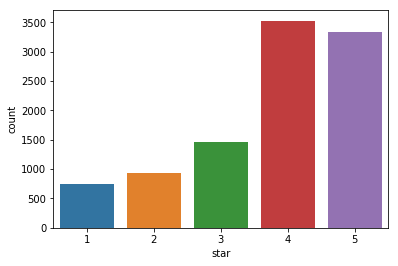

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


sns.countplot(x ='star', data = yelp_df) 

plt.show()



### Insight

When we combine our analysis of the number of businesses a user reviews with how the number of stars are distributed with we might learn something interesting. 

- The ratio of unique values for star is 0.000600 , for texts is 0.999800 , for business id is 0.417458 , and user id is 0.640336. 

- In regard to the amount of businesses each user reviews the Max is 38 , the Min is 1 , the Mean is 1.561680199875078 , and the Median is 1.0. For our purposes the mean and median are both 1. The 25th percentile is 1.000000 , the 50th percentile is 1.000000 , 75th percentile 1.000000. 


- In regard to the amount of stars given for a review the mean is 3.777500 , min is 1.000000 , 25th percentile is 3.000000, median is 4.000000, 75th percentile is 5.000000 , max is 5.000000.

- The distribution of the stars has a increase in amount of stars given from the min of 1 star to the median of 4 stars and then a decrease for the remaining value of 5 stars.

If the bid is around 41.7% unique that means it is around 59.3% values that repeat at least once. If the uid is 64% unique that means it is 36% values that repeat at least once. When we combine the 59.3% not unique businesses with the 64% unique users we gain some insight. Every user must have at least one business reviewed. 

Which means if we assume bid and uid barely overlap (as much unique users review as much unique businesses as possible), then still 22.3% of unique users would have reviewed a business that is already reviewed by someone else. If we assume bid and uid overlap as much as possible(as much unique users review as little unique businesses possible), then 4.7% of of unique users would review an unique business. This means 95.3% of unique users would have reviewed a business that is already reviewed by someone else. This means the min percentage of users who reviewed more than one allowed is 22.3% and the max is 95.3%.

However , this can not be true. We know that the 75th percentile is still 1. Which means 75% of the businesses that are reviewed are less than or equal to 1. So by default 75% of the range of businesses that are reviewed per user must be at max 1. The true range now is the top 22.3% to 25%. Another way of looking at it is all values between 1st to 75th percentile must be 1 since the min is 1 and the possible value series greater than 1 can start anywhere between the 75th percentile to the 77 percentile. Either way a series roughly equal to the top 22% of the data is always greater than one.

Most reviews are positively skewed with a median of 4 stars. 50% of all reviews are reviews that are 4 stars or less. =The bottom 25% ( up to the 25th percentile) are reviews that are 3 stars or less. From 25th percentile to 50th =percentile the reviews could be 3 stars or 4 stars. From the 50th percentile to the 75th percentile the reviews could =be 4 stars or 5 stars. And the top 25%( 75th percentile to max) must be 5 stars. 

The combination of these two datasets tells us that if the top 50% of reviews can only be 4 stars or 5 stars and 75% of the unique users( which are a subset of all user reviews) reviewed only 1 business, then unless the duplicate user reviews operate under a very different review pattern we can say that users who review only 1 business choose a variety of different stars for the reviews. It is not correct to say a user who reviews 1 business has number of stars they will trend toward.

## DELETE? But need to change ratings to discrete value
### Analyzing cool , funny, useful ratings

Before we can plot the features cool , funny and useful we have a problem. We would prefer if all these ratings were consistent in what they mean, and in a form friendly to graphing. But how should we do this?

We will do this by turning numeric values into a scheme of low , mid , high. Low will start at 25% of the range , mid will start at 50% of the range and high will start at 75% of the range. In the past we used percentiles to navThigate from the min to the max. This was because we needed to take into account the frequency of each value. Now we don't. We only care about the distance between the min value and max value. For example:

If we had a series of values [ 0, 75,75,75,100] , the 50th percentile is 75. However the middle distance the min 1 and the max 100 is 50. Let's double check by using the formula ((n-min)/(max-min))*100. (50-0)/(100-0)=.5 *100 = 50%

Distance does not care how many times a value is shown , it only needs the min and max to determine the percentage. This is what we want since low , mid , and high are just the range seperated into parts. To be exact will will make the bottom 25% of the range low and the top 25% high. The remaining will become mid. 

In the example we knew what the value we wanted was and through the calculations we found the percentage. To get our values we have to change the formula to assume the percentage to calculate the values we will use to divide the range. The new equation is S=1/100(P*max+100*min−P*min) 



In [8]:


#cool transformation
top = (1/100)*(75*yelp_df['cool'].unique().max()+100*yelp_df['cool'].unique().min()-75*yelp_df['cool'].unique().min()) 
mid = (1/100)*(50*yelp_df['cool'].unique().max()+100*yelp_df['cool'].unique().min()-50*yelp_df['cool'].unique().min()) 
bottom = (1/100)*(25*yelp_df['cool'].unique().max()+100*yelp_df['cool'].unique().min()-25*yelp_df['cool'].unique().min())
# Useful Tranformation
top1 = (1/100)*(75*yelp_df['useful'].unique().max()+100*yelp_df['useful'].unique().min()-75*yelp_df['useful'].unique().min()) 
mid1 = (1/100)*(50*yelp_df['useful'].unique().max()+100*yelp_df['useful'].unique().min()-50*yelp_df['useful'].unique().min()) 
bottom1 = (1/100)*(25*yelp_df['useful'].unique().max()+100*yelp_df['useful'].unique().min()-25*yelp_df['useful'].unique().min())
# Funny Transformation
top2 = (1/100)*(75*yelp_df['funny'].unique().max()+100*yelp_df['funny'].unique().min()-75*yelp_df['funny'].unique().min()) 
mid2 = (1/100)*(50*yelp_df['funny'].unique().max()+100*yelp_df['funny'].unique().min()-50*yelp_df['funny'].unique().min()) 
bottom2 = (1/100)*(25*yelp_df['funny'].unique().max()+100*yelp_df['funny'].unique().min()-25*yelp_df['funny'].unique().min())


yelp_df['cool'] = yelp_df['cool'].apply(lambda x: 'Low' if x < bottom else 'High' if x > top else 'Middle')
yelp_df['useful'] = yelp_df['useful'].apply(lambda x: 'Low' if x < bottom1 else 'High' if x > top1 else 'Middle')
yelp_df['funny'] = yelp_df['funny'].apply(lambda x: 'Low' if x < bottom else 'High' if x > top else 'Middle')
np.unique(df['funny'] , return_counts=True)
top , mid , bottom

(57.75, 38.5, 19.25)

### Analyse review comment text length

We would like to know more about the comments in the text field since the comments are what we will try to predict. We need to find a variable about te text to compare to the stars. One of the easiest variables you can use to find more insights is the length or word count of a texts as it doesn't require too much analysing and returns a numeric value.

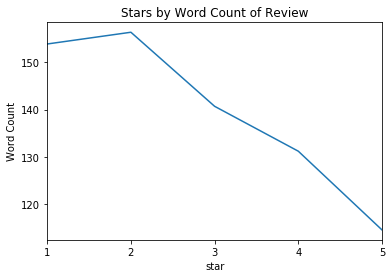

In [9]:



yelp_df['count'] = yelp_df['texts'].str.split().apply(lambda x:len(x))
plt.title('Stars by Word Count of Review')
g = yelp_df.groupby('star')['count'].mean().plot()
g.locator_params(integer=True)
plt.ylabel('Word Count')
plt.show()


In [10]:
from sklearn.model_selection import train_test_split
X = yelp_df['texts']
y = yelp_df['star']
# Split data X into train/test and labels Y into train/split ( test=0.2 , train=0.8)
#X_train , X_test , Y_train , Y_test =  train_test_split(X, y, test_size=0.2 , random_state=0)
#len(X_train) , len(X_test) , len(Y_train), len(Y_test)

In [11]:
#Preview data
import numpy as np 
import re # regular expression
import nltk
nltk.download("stopwords") # download stop words & wordnet
nltk.download("wordnet")
import pickle # transfer python objects by turning into byte form
from nltk.corpus import stopwords
from sklearn.datasets import load_files

[nltk_data] Downloading package stopwords to /home/adam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/adam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
documents = []
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer() # reduce the word into dictionary root form

for sen in range(0, len(X)):
    document = re.sub(r'\W', ' ' ,str(X[sen])) # remove all spcial characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)  # remove all single characters
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) # Remove single characters from the start
    document = re.sub(r'\s+', ' ', document, flags=re.I)# Substituting multiple spaces with single space
    document = document.lower()  # Converting to Lowercase
    document = document.split()# Split the str document by space and turn into list
    document = [stemmer.lemmatize(word) for word in document] #Lemmatization = reduce the word into dictionary root form
    document = ' '.join(document)
    documents.append(document)
len(documents)

10000

In [13]:
 # Convert text into the corresponding numerical form
from sklearn.feature_extraction.text import CountVectorizer
 # max_feature= 1500 : use 1500 most occurring words as features for training classifier
 # min_df = 5 : minimum number of documents that should contain the word
 # max_df = 0.7 : include only those words that occur in a maximum of 70% of all the documents
 # stop_words = stopwords.words('english')  : remove stopwords from text
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  
 # Convert
#print(vectorizer.fit_transform(documents))  
X = vectorizer.fit_transform(documents).toarray()
type(X)


numpy.ndarray

In [17]:
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
# convert values obtained using the bag of words model into TFIDF values
from sklearn.feature_extraction.text import TfidfTransformer
# Not Yet , Compare with or without
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# Split data X into train/test and labels Y into train/split ( test=0.2 , train=0.8)
tfdconverter =  TfidfTransformer()
X_IDF = tfdconverter.fit_transform(X).toarray()
X_train , X_test , Y_train , Y_test =  train_test_split(X_IDF, y, test_size=0.2 , random_state=0)

In [18]:

# Create classifier with 1000 trees in the random forest
classifier = RandomForestClassifier(random_state=0)

In [19]:
param = { 'n_estimators': [800,1000,1200] , 'criterion' :['gini', 'entropy']}
#temp = GridSearchCV(estimator=classifier, param_grid=param , scoring='accuracy', cv= 5)
CV = RandomizedSearchCV(estimator = classifier, param_distributions = param, scoring='accuracy', n_iter=4,cv=5, verbose=0, random_state=0)
# train classifier with X data and Y labels and use classifier to predict Y_test with X_test data
CV.fit(X_train , Y_train)
#ypred = classifier.predict(X_test)
print(CV.best_params_)
print(CV.best_score_)
print(CV.best_estimator_)

{'n_estimators': 1000, 'criterion': 'gini'}
0.480375
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [20]:
pred_Y = CV.predict(X_test)
pred_Y

array([4, 4, 4, ..., 4, 5, 4])

In [ ]:
 # max_feature= 1500 : use 1500 most occurring words as features for training classifier
 # min_df = 5 : minimum number of documents that should contain the word
 # max_df = 0.7 : include only those words that occur in a maximum of 70% of all the documents
 # stop_words = stopwords.words('english')  : remove stopwords from text
from itertools import *
import matplotlib.pyplot as plt
import seaborn as sns
class tunning:
    def __init__(self,IDF , max_feat , min_df ,max_df):
        self._IDF = IDF
        self._max_feat = max_feat
        self._min_df = min_df
        self._max_df = max_df
        self._key = ['max_feat' ,  'min_df' , 'max_df']
        self._val = [self._max_feat,self._min_df, self._max_df]
        self._metric_dic = dict(zip(self._key , self._val))
    def set_IDF(self, IDF):
        self._IDF = IDF
    def set_metrics(self, metric_name , metric_value):
        self._metric_dic[metric_name] = metric_value
        
    def get_IDF(self):
        return self._IDF
    def get_metrics(self):
        return self._metric_dic
    #def plot(self, error_val , ):
        
        
        
    #def del_IDF(self, ):
    #def del_metrics(self, ):


In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(Y_test , pred_Y))
print(confusion_matrix(Y_test , pred_Y, labels=[1,0]))
print(classification_report(Y_test , pred_Y))
#sns.lineplot(accuracy_score(Y_test , ypred), )

0.478
[[42  0]
 [ 0  0]]
              precision    recall  f1-score   support

           1       0.78      0.32      0.45       133
           2       0.50      0.01      0.03       206
           3       0.46      0.07      0.13       281
           4       0.42      0.69      0.52       706
           5       0.56      0.59      0.58       674

   micro avg       0.48      0.48      0.48      2000
   macro avg       0.54      0.34      0.34      2000
weighted avg       0.50      0.48      0.43      2000

